# About Project

## Deciding whether the person is effected to heart disease or not

 ### The data set contains 14 features with 303 patient samples <br> <br>All these features may or may not be directly correlated to the target value (has heart disease or not). <br><br> So extracted features using feature selection using Mutual Information) <br><br> Creatied a model metrics compared with no feature selection and with feature selection.

# Input File

In [25]:
#csv file name

name="heart disease classification dataset.csv"

# Libraries

In [26]:
import csv
import pandas as pd
import re
import sqlite3
from sklearn import neighbors
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.random.seed(1234)
start=time.time()

# Processing the CSV file extracting Header and rows

In [27]:

class process_file:   # Preprocess the data by reading the csv file.
    
    def __init__(self,file_name,delimiter,header,first_omit):
        print(file_name)
        self.file_name=file_name
        self.delimiter=delimiter
        self.header=header
        self.first_omit=first_omit
        
    def read_file(self):   # extracting the header and the rows from the csv.
        print("Reading the CSV File...")
        self.rows=[]
        with open(self.file_name) as file:
            if self.delimiter==None:
                content=csv.reader(file)
            else:
                content=csv.reader(file,delimiter=self.delimiter)
            if self.header==True and self.first_omit==True:
                self.header = next(content)
                self.header=self.header[1:]
                [self.rows.append(i[1:]) for i in (content)]
            else:
                self.header = next(content)
                [self.rows.append(i) for i in (content)]
            
            table_data=self.data_type()
        return table_data
            
    def data_type(self):    # Getting the data type of the header.
        print("Getting data type of the features by taking header...")
        first_row=self.rows[0]
        temp_dict=dict.fromkeys(self.header,0)
        
        for i in range(0,len(first_row)):
            if (re.compile('[0-9]+\.[0-9]+')).match(first_row[i]):
                temp_dict[self.header[i]]="double"
                
            elif (re.compile('^[0-9]+$')).match(first_row[i]):
                temp_dict[self.header[i]]="Number"
        
            else:
                temp_dict[self.header[i]]="varchar"
                
        self.table_head=temp_dict
        
        file_name=self.file_name.split("/")[-1].split(".")[0]
        create_preprocess_obj=Preprocess_data(self.table_head.values(),self.rows)
        insert_rows_data=list(create_preprocess_obj)
        normalize_tables(file_name,self.table_head,insert_rows_data)
        

# Pre-process the data (Handling Missing values)

In [28]:
class Preprocess_data():   # Preprocess the data ie.. inserting missing values in the rows.
    
    def __init__(self,values,rows):
        print("Pre-process the data when no data present with respect to data types...")
        self.final_rows_list=[]
        values=list(values)
        for i in rows:
            temp=""
            for j in range(0,len(values)):
                if values[j]=="varchar":
                    i[j]="\""+i[j]+"\""
                if i[j]=="":
                    if values[j]=="Number":
                        i[j]="0"
                    elif values[j]=="double":
                        i[j]="0.0"
                    else:
                        i[j]="null"
                temp+=i[j]+","
            self.final_rows_list.append(temp[0:len(temp)-1])
        
    def __iter__(self):  #return the list of the rows using iter.
        
        return iter(self.final_rows_list)
    

# Create Database

In [29]:
class create_database:   # Creating the db, table and inserting the rows into db.
    
    def __init__(self,file_name):
        print("Creating the data base.....")
        global conn,cur
        file_name=file_name.replace(" ","")
        column_names="("
        conn=sqlite3.connect(file_name+".db;")
        cur=conn.cursor()

# Creating and Inserting Normalised tables

In [30]:
class create_insert_data_table:        # Creating and inserting normalised tables.
    
    def __init__(self,col_name,col_data_type,rows):
        print("Creating Normalised tables  "+col_name)
        dict_country={}
        drop_table="drop table if exists "+col_name+";"
        conn.execute(drop_table)
        conn.commit()
        
        create_table="create table if not exists "+col_name+"("+col_name+"id integer Primary Key autoincrement,"+col_name+" "+col_data_type+" not null)"
        table=conn.execute(create_table)
        conn.commit()
        
        insert_query="Insert or replace into "+col_name+" ("+col_name+") values "
        for i in rows:
            insert_query+="("+i+"),"
           
        insert_query=insert_query[0:len(insert_query)-1]+";"
        insert_rows=conn.execute(insert_query)
        conn.commit()

        sql_statement="select * from "+col_name+";"
        cur = conn.cursor()
        cur.execute(sql_statement)

        data = cur.fetchall()
        for i in data:
            dict_country[str(i[1])]=i[0]
        df.append(dict_country)
        

# Heart Disease table creation and Insertion

In [31]:
class heart_disease:          # Final table
    
    def __init__(self,file_name,tables,table_head,rows_data):
        print("Creating the Final table.....")
        global rows
        table_name=file_name.replace(" ","_")
        foreign_key=""
        column_names=""
        
        drop_table="drop table if exists "+table_name+";"
        conn.execute(drop_table)
        conn.commit()
        
        
        create_table="create table if not exists "+table_name+"("
        for i in table_head:
            column_names+=i[0]+","
            create_table+=i[0]+" "+i[1]+" not null,"
            if i[0] in tables:
                foreign_key+="foreign key("+i[0]+") references "+ i[0]+"("+i[0]+"),"
                
        create_table+=foreign_key[:len(foreign_key)-1]+")"
        table=conn.execute(create_table)
        conn.commit()
       
        print("Inserting Records into the table.....")
        column_names=column_names[0:len(column_names)-1]
        insert_query="Insert into "+table_name+" ("+column_names+") values "
        final_data=[]
        
        for i in rows_data:
            i=i.split(",")
            data=""
            for j in range(0,len(i)):
                if table_head[j][0] in tables:
                    key=tables.index(table_head[j][0])
                    key=df[key]
                    value=i[j].replace("\"","")
                    value=key[value]
                else:
                    value=i[j]
                data+=str(value)+","
            final_data.append(data[:len(data)-1])
            
        for i in final_data:
            insert_query+="("+i+"),"
        insert_rows=conn.execute(insert_query[:len(insert_query)-1])
        conn.commit()
        
        self.display_rows(table_name)
        
    def display_rows(self,table_name):   # Displaying the rows in the table and returning it.
        print("Displaying the Data in the table....\n")
        global rows
        global row
        sql_statement="select * from "+table_name+";"
        row = pd.read_sql_query(sql_statement, conn)
        rows = pd.read_sql_query(sql_statement, conn)
        m={'2':'male','1':'female'}
        row['sex']=row['sex'].map(m)
        

# Normalize tables Identifying and creating normalised and Heart disease table

In [32]:
class normalize_tables(process_file):
    def __init__(self,file_name,table_head,rows_data):
        print("Extracting the columns to create Normalise Tables....")
        global tables
        create_database("heart disease classification dataset")
        tables=[]
        n=(len(table_head))
        table_head=list(table_head.items())
        col_data=[]
        global df
        df=[]
        
        print("Checking and creating the Normalised tables...")
        for j in range(0,n-1):
            for i in rows_data:
                col_data.append(i.split(",")[j])
            col_data=sorted(set(col_data))
            if len(col_data)<5:
                tables.append(table_head[j][0])
                create_insert_data_table(table_head[j][0],table_head[j][1],col_data)
            col_data=[]
            
        heart_disease("Heart_disease_classification_dataset",tables,table_head,rows_data)

In [33]:
process_file_obj=process_file(name,None,True,True)
data_retrieve=process_file_obj.read_file()

heart disease classification dataset.csv
Reading the CSV File...
Getting data type of the features by taking header...
Pre-process the data when no data present with respect to data types...
Extracting the columns to create Normalise Tables....
Creating the data base.....
Checking and creating the Normalised tables...
Creating Normalised tables  sex
Creating Normalised tables  cp
Creating Normalised tables  fbs
Creating Normalised tables  restecg
Creating Normalised tables  exang
Creating Normalised tables  slope
Creating Normalised tables  thal
Creating the Final table.....
Inserting Records into the table.....
Displaying the Data in the table....



# Information Related to Data

In [34]:
#Sample Normalised table

sql_statement="select * from sex;"
data = pd.read_sql_query(sql_statement, conn)
display(data)

,sexid,sex
0,1,female
1,2,male


In [35]:
#displaying Heart_disease_table

display(rows)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,2,4,145,233,2,1,150,1,2.3,1,0,2,yes
1,37,2,3,130,250,1,2,187,1,3.5,1,0,3,yes
2,41,1,2,130,204,1,1,172,1,1.4,3,0,3,yes
3,56,2,2,120,236,1,2,178,1,0.8,3,0,3,yes
4,57,1,1,0,354,1,2,163,2,0.6,3,0,3,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,1,1,140,241,1,2,123,2,0.2,2,0,4,no
299,45,2,4,110,264,1,2,132,1,1.2,2,0,4,no
300,68,2,1,144,193,2,2,141,1,3.4,2,2,4,no
301,57,2,1,0,131,1,2,115,2,1.2,2,1,4,no


In [36]:
display(rows.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    object 
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


None

In [37]:
rows.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,1.966997,129.973597,245.504950,1.148515,1.528053,147.392739,1.326733,1.039604,2.399340,0.729373,3.313531
std,9.082101,1.032052,23.095668,53.719524,0.356198,0.525860,29.434756,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,47.500000,1.000000,120.000000,211.000000,1.000000,1.000000,132.000000,1.000000,0.000000,2.000000,0.000000,3.000000
50%,55.000000,2.000000,130.000000,240.000000,1.000000,2.000000,152.000000,1.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,3.000000,140.000000,274.500000,1.000000,2.000000,166.000000,2.000000,1.600000,3.000000,1.000000,4.000000
max,77.000000,4.000000,200.000000,564.000000,2.000000,3.000000,202.000000,2.000000,6.200000,3.000000,4.000000,4.000000


# Visualization

/Users/tejaswinioruganti/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

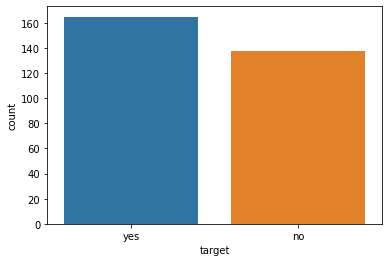

In [38]:
sns.countplot("target",data=rows)

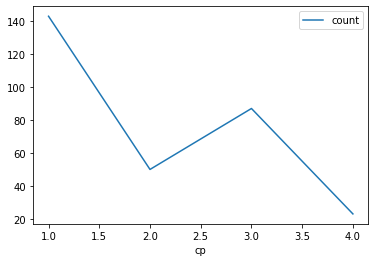

In [39]:
#comparing cp with restecg.
#Comparing the cp with restecg by grouping cp.

stmt="SELECT cp, count(restecg) count FROM heart_disease_classification_dataset Group By cp"
data=pd.read_sql_query(stmt,conn)
data.plot(x ='cp', y='count', kind = 'line')
plt.show()

<AxesSubplot:xlabel='sex'>

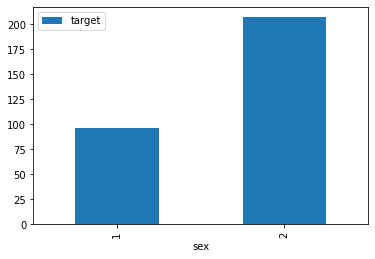

In [40]:
# Comparing the target value feature among the Male and Female.

stmt="SELECT  (sex) , count(target) target  FROM heart_disease_classification_dataset Group By sex"
data=pd.read_sql_query(stmt,conn)
data.plot(x="sex", y=["target"], kind="bar")


<AxesSubplot:xlabel='age', ylabel='[chol]'>

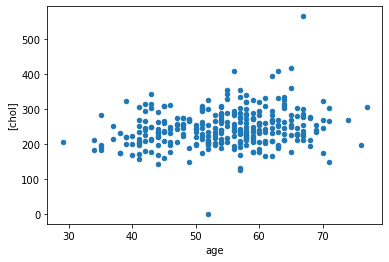

In [41]:
# Scatter plot representing the levels of cholestrol for each of the ages.

stmt="SELECT age, chol FROM heart_disease_classification_dataset "
data=pd.read_sql_query(stmt,conn)
data.plot(x="age", y=["chol"], kind="scatter")

<AxesSubplot:xlabel='target'>

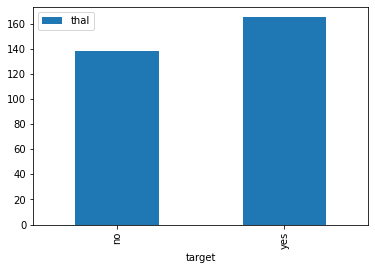

In [42]:
# Bar graph representing the the count of people who are affected by thal and heart disease.

stmt="SELECT target, count(thal) thal FROM heart_disease_classification_dataset group by target"
data=pd.read_sql_query(stmt,conn)
data.plot(x="target", y=["thal"], kind="bar")

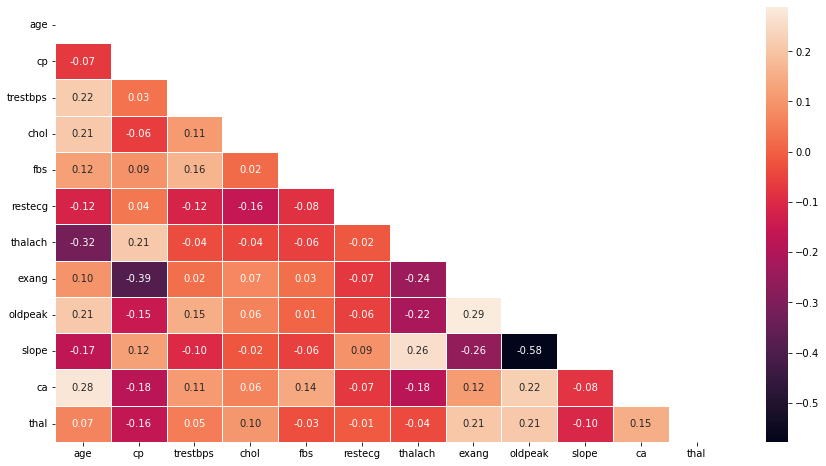

In [43]:
# Correlation graph

corr = rows.corr()
fig, ax = plt.subplots(figsize=(15, 8))
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

### From the above correlation graph, we can easily understand that exang,chol,ca,thal,oldpeak and cp  are important because of high correlation that means have dependencies over another

# Machine Learning Techniques

In [44]:
class algo:
    
    def __init__(self,val,x,y):
        print("\n Machine Learning Algorithms Implementations.....")
        self.val=val
        self.x_train,self.x_test,self.y_train,self.y_test = train_test_split(x, y, test_size=0.20)
        self.knn()
        self.nb()
        self.svm()
        self.bag()
        self.boost()
        self.graph()
        
    def Metric_Calculation(self,predicted,expected):
        
        a=metrics.accuracy_score(expected,predicted,normalize=True,sample_weight=None)
        acc.append(a*100)
        
        precision = precision_score(expected,predicted,average='weighted')
        pre.append(precision*100)
        
        recall = recall_score(expected, predicted, average='weighted')
        re.append(recall*100)
     
        f1 = f1_score(expected, predicted, average='weighted')
        f.append(f1*100)

        print("Accuracy: "+str(a*100))
        print("precision: "+str(precision*100))
        print("Recall: "+str(recall*100))
        print("F1: "+str(f1*100))   
     
    # Implementation of KNN algorithm
    def knn(self):

        print("\n------   "+self.val+" KNN   -----\n")
        knn=neighbors.KNeighborsClassifier()
        knn.fit(self.x_train,self.y_train)
        predicted=knn.predict(self.x_test)
        expected=self.y_test
        self.Metric_Calculation(predicted,expected)
        
        
    # Implementation of Naive Bayes algorithm    
    def nb(self):
        print("\n------   "+self.val+" Naive Bayesian   -----\n")
        classifier = GaussianNB()
        classifier.fit(self.x_train,self.y_train)
        predicted =classifier.predict(self.x_test)
        #print(predicted)
        expected=self.y_test
        self.Metric_Calculation(predicted,expected)
    
    # Implementation of SVM algorithm
    def svm(self):
        print("\n-----   "+self.val+" SVM   -----\n")
        clf = svm.SVC()
        clf.fit(self.x_train,self.y_train)
        predicted = clf.predict(self.x_test)
        expected=self.y_test
        self.Metric_Calculation(predicted,expected)

    # Implementation of Ensemble method - Bagging algorithm   
    def bag(self):
        print("\n-----   "+self.val+" Bagging   -----\n")
        bgclassifier = BaggingClassifier()
        bgclassifier.fit(self.x_train,self.y_train)
        predicted = bgclassifier.predict(self.x_test)
        expected=self.y_test
        self.Metric_Calculation(predicted,expected)

    # Implementation of Ensemble method - Boosting algorithm
    def boost(self):
        print("\n-----   "+self.val+" Boosting   -----\n")
        model = GradientBoostingClassifier()
        model.fit(self.x_train,self.y_train)
        predicted = model.predict(self.x_test)
        expected=self.y_test
        self.Metric_Calculation(predicted,expected)        
    
    # Visualization of metrics
    def graph(self):
        algos = ["KNN","Naive Bayes","SVM","Bagging","Boosting"]
        fig, ax = plt.subplots(figsize=(15,5))
        w = 0.21
        bar1_x_position = np.arange(len(algos))
        bar2_x_position = [ i+w for i in bar1_x_position ]
        bar3_x_position = [ i+w for i in bar2_x_position ]
        bar4_x_position = [ i+w for i in bar3_x_position ]
        

        a=plt.bar(bar1_x_position,acc,w,label="accuracy")
        b=plt.bar(bar2_x_position,pre,w,label="precision")
        c=plt.bar(bar3_x_position,re,w,label="recall")
        d=plt.bar(bar4_x_position,f,w,label="F1")

        plt.title(self.val+" Metrics data",fontweight="bold",fontsize=18)
        plt.xlabel("Algorithms",fontsize=12,fontweight="bold")
        plt.ylabel("metric value",fontsize=12,fontweight="bold")
        plt.xticks(bar1_x_position+w/2+w,algos,fontsize=10)
        plt.yticks(fontsize=20)
        plt.legend(fontsize = 14,bbox_to_anchor=(1.05, 1),loc='upper left')
        graph=[a,b,c,d]
        values=[acc,pre,re,f]
        
        flag=0
        for g in graph:
            i = 0
            
            for k in g:
                height=k.get_height()
                width = k.get_width()
                x, y = k.get_xy()
                plt.text(x+width/2,
             y+height*1.01,
             str(round((values[flag])[i],1)),
             ha='center')
                i=i+1
            flag = flag + 1
        plt.show()

# Feature selection using Mutual Information

In [45]:
# Feature Selection

class Feature_Selecetion:
    
    def __init__(self):
        feature_extract=[]
        x = rows.iloc[: , :-1]
        y=rows.iloc[:,-1]
        global acc,f,pre,re
        acc=[]
        f=[]
        pre=[]
        re=[]
        algo("No-Feature-Selection",x,y)
        
        mut_info=MIC(x, y)
        base=(sum(mut_info)/len(mut_info))
        for i in range(0,len(mut_info)):
            if mut_info[i]>= base:
                feature_extract.append(i)
        global extract_features
        extract_features=(rows.iloc[:,feature_extract])
        
        
        acc=[]
        f=[]
        pre=[]
        re=[]
        print("Feature extraction Method....")
        algo("Feature-Selection",extract_features,y)



 Machine Learning Algorithms Implementations.....

------   No-Feature-Selection KNN   -----

Accuracy: 63.934426229508205
precision: 63.779353123615415
Recall: 63.934426229508205
F1: 63.577733741668176

------   No-Feature-Selection Naive Bayesian   -----

Accuracy: 70.49180327868852
precision: 70.49180327868852
Recall: 70.49180327868852
F1: 70.49180327868852

-----   No-Feature-Selection SVM   -----

Accuracy: 62.295081967213115
precision: 64.4624842370744
Recall: 62.295081967213115
F1: 58.88903697780147

-----   No-Feature-Selection Bagging   -----

Accuracy: 77.04918032786885
precision: 77.0419744190236
Recall: 77.04918032786885
F1: 76.96167720275724

-----   No-Feature-Selection Boosting   -----

Accuracy: 75.40983606557377
precision: 75.78497205236899
Recall: 75.40983606557377
F1: 75.07028671547124


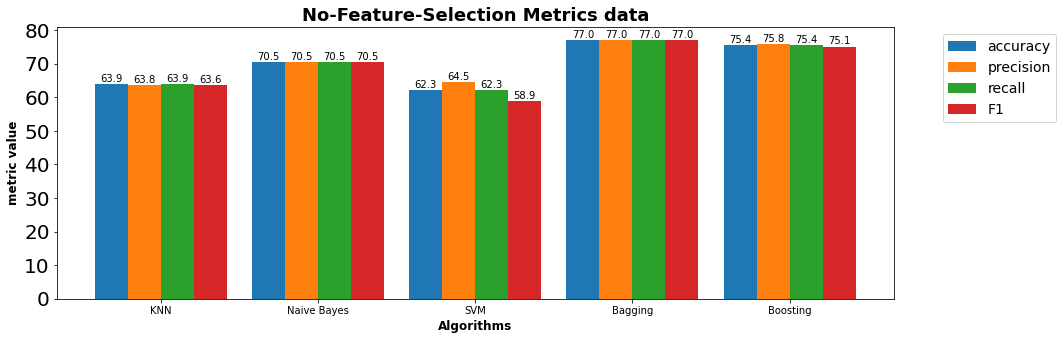

Feature extraction Method....

 Machine Learning Algorithms Implementations.....

------   Feature-Selection KNN   -----

Accuracy: 65.57377049180327
precision: 65.41894353369763
Recall: 65.57377049180327
F1: 65.47869667377458

------   Feature-Selection Naive Bayesian   -----

Accuracy: 85.24590163934425
precision: 85.21129326047358
Recall: 85.24590163934425
F1: 85.20515571733195

-----   Feature-Selection SVM   -----

Accuracy: 59.01639344262295
precision: 57.95225769341387
Recall: 59.01639344262295
F1: 57.6916708064249

-----   Feature-Selection Bagging   -----

Accuracy: 81.9672131147541
precision: 83.26282390269698
Recall: 81.9672131147541
F1: 82.06455609389172

-----   Feature-Selection Boosting   -----

Accuracy: 85.24590163934425
precision: 85.80236009044658
Recall: 85.24590163934425
F1: 85.31797050514936


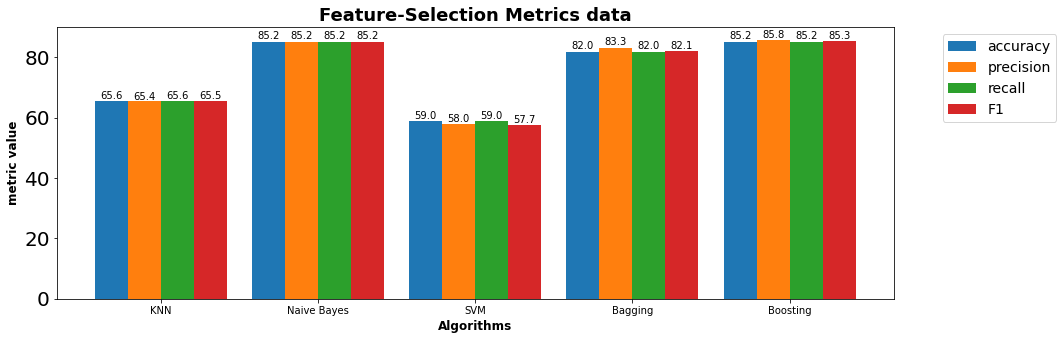

In [46]:
x=Feature_Selecetion()
end=time.time()

### Extracted Features ------  These gives more significance in finding whether the person has heart disease or not..

In [47]:
display(extract_features)

,cp,chol,restecg,exang,oldpeak,ca,thal
0,4,233,1,1,2.3,0,2
1,3,250,2,1,3.5,0,3
2,2,204,1,1,1.4,0,3
3,2,236,2,1,0.8,0,3
4,1,354,2,2,0.6,0,3
...,...,...,...,...,...,...,...
298,1,241,2,2,0.2,0,4
299,4,264,2,1,1.2,0,4
300,1,193,2,1,3.4,2,4
301,1,131,2,2,1.2,1,4


# Time taken to Execute the Code

In [48]:
print("Time Taken to execute the Model is ------- ", end-start,"ms")

Time Taken to execute the Model is -------  7.928771018981934 ms


# Before Feature selection Bagging is best

# After feature selection Boosting is best

## In conclusion, there are 14 features and not all these are correlated to predict the patient status whether he/she has heart disease or not. So these are the 6 features that are mostly contributed in predicting the disease those are : exang,chol,ca,thal,oldpeak and cp.

## By concentrating on these levels there is 85% chances of a person get rid of attacking the heart disease.